In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression, ridge_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tqdm import tqdm
import shap
from shap import explainers
import ipywidgets as widgets
from ipywidgets import interact
from tqdm import tqdm

# Load and preprocess

In [12]:
def merge_location(df):
    print(df['CountryName'], df['RegionName'])
    country = df['CountryName'].iloc[0]
    region = df['RegionName'].iloc[0]
    area = '-'.join(filter(None, [country, region]))
    df['Area'] = area
    return df

LABEL_COLS = ['R_mean']
FEAT_COLS = ['C1_Flag', 'C1_School closing', 'C2_Flag', 'C2_Workplace closing', 'C3_Cancel public events', 
             'C3_Flag', 'C4_Flag', 'C4_Restrictions on gatherings', 'C5_Close public transport', 'C5_Flag', 
             'C6_Flag', 'C6_Stay at home requirements', 'C7_Flag', 'C7_Restrictions on internal movement', 
             'C8_International travel controls', 'E1_Flag', 'E1_Income support', 'E2_Debt/contract relief', 
             'H1_Flag', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 
             'H5_Investment in vaccines', 'H6_Facial Coverings', 'H6_Flag', 'H7_Flag', 'H7_Vaccination policy', 
             'H8_Flag', 'H8_Protection of elderly people', 'Population', 'PopulationDensity', 
             'V1_Vaccine Prioritisation (summary)', 'V2A_Vaccine Availability (summary)', 
             'V2B_Vaccine age eligibility/availability age floor (general population summary)', 
             'V2C_Vaccine age eligibility/availability age floor (at risk summary)', 
             'V2D_Medically/ clinically vulnerable (Non-elderly)', 'V2E_Education', 
             'V2F_Frontline workers  (non healthcare)', 'V2G_Frontline workers  (healthcare)', 
             'V3_Vaccine Financial Support (summary)', 'V4_Mandatory Vaccination (summary)',
             'CountryName']
LOG_COLS = ['H5_Investment in vaccines', 'Population', 'PopulationDensity']
n_country = 0


def shift(df, shift=14):
    feats = df[FEAT_COLS]
    labels = df[LABEL_COLS]
    if shift != 0:
        labels = labels.shift(-shift).iloc[:-shift]
    return feats.merge(labels, how='inner', left_index=True, right_index=True)

def get_data(s=0, drop_ct=True):
    global n_country
    data = pd.read_csv('../data/estims_all.csv', dtype={'RegionName':str})
    n_country = len(data['CountryName'].unique())
    data = data[pd.isna(data['RegionName'])] # remove regions since they do not have population data
    data[LOG_COLS] = np.log(1 + data[LOG_COLS])
    # data.fillna({'RegionName': ''}, inplace=True)
    # data = data.groupby(['CountryName', 'RegionName']).apply(merge_location)
    data.drop(columns=['R_var', 'Q0.025', 'Q0.5', 'Q0.975', 'cases', 'Date', 'RegionName', 'Jurisdiction'], inplace=True)
    
    data = data.groupby('CountryName', group_keys=False).apply(shift, shift=s).reset_index(drop=True)
    
    # data.drop(columns=['CountryName'], inplace=True)
    y = pd.get_dummies(data['CountryName'], prefix='Country')
    areas = data['CountryName']
    data = data.merge(y, left_index=True, right_index=True, how='inner')
    
    if drop_ct:
        data = data.drop(columns=['CountryName'])

    return data

# rename the flag columns
def rename(col_name):
    if 'Flag' in col_name:
        # search for corresponding non-flag column
        code = col_name.split('_',1)[0]
        non_flag = list(filter(lambda x: code in x and 'Flag' not in x, FEAT_COLS))
        assert len(non_flag) == 1
        return non_flag[0] + '_Flag'
    else:
        return col_name

# Train to predict R_t

In [34]:
data = get_data(14)
data = data.rename(rename, axis='columns')
Y = data['R_mean']
X = data.drop(columns=['R_mean'])

In [25]:
scaler = MinMaxScaler()
# model = LinearRegression()
model = RandomForestRegressor(n_estimators=10)

In [73]:
scores = []

kfold = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
for train_idx, val_idx in tqdm(kfold.split(X.index, areas)):
    train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
    train_y, val_y = Y.iloc[train_idx], Y.iloc[val_idx]
    train_x = scaler.fit_transform(train_x)
    val_x = scaler.transform(val_x)
    
    model.fit(train_x, train_y)
    score = model.score(val_x, val_y)
    scores.append(score)
    
print(scores)
print(np.mean(scores))

5it [01:00, 12.14s/it]

[-0.19758239357197294, -0.8436701025261715, -0.33795507800797364, -0.1982666111847644, -1.2356287421918415]
-0.5626205854965448


# Result

+ random forest (shuffle): [0.780965544486699, 0.7885151695642806, 0.8012048453095675, 0.7907898000552722, 0.7953448227960056] => 0.791364036442365
+ random forest (no shuffle): [-0.18571328679546184, -0.927070106311638, -0.16726759522169976, 0.021319901072995084, -0.9997124714349126] => -0.4516887117381434

# SHAP values

In [26]:
train_x = scaler.fit_transform(X)
model.fit(train_x, Y)

RandomForestRegressor(n_estimators=10)

In [27]:
explainer = explainers.Tree(model, model_output='raw')
# print the JS visualization code to the notebook
shap.initjs()

In [9]:
np.random.seed(1337)
idxs = np.random.randint(0,len(train_x)-1, n_country * 50)
shap_values = explainer.shap_values(train_x[idxs])

In [10]:
np.save('shap_values.npy', shap_values)
np.save('idxs.npy', idxs)

In [28]:
shap_values = np.load('shap_values.npy')
idxs = np.load('idxs.npy')

In [34]:
# inspect each sample
def plot(idx):
    shap_value_single = explainer.shap_values(train_x[idx])

    shap.force_plot(base_value = explainer.expected_value,
                    shap_values = shap_value_single,
                    features = X.columns,
                    matplotlib=True)
    
interact(plot, idx=(0,len(X)-1))

interactive(children=(IntSlider(value=71409, description='idx', max=142819), Output()), _dom_classes=('widget-…

<function __main__.plot(idx)>

## Plot only NPI features

In [35]:
n_features = 25
npis = list(filter(lambda x: 'Country' not in x, X.columns))
# print(npis)
npi_idxs = [X.columns.get_loc(c) for c in npis]

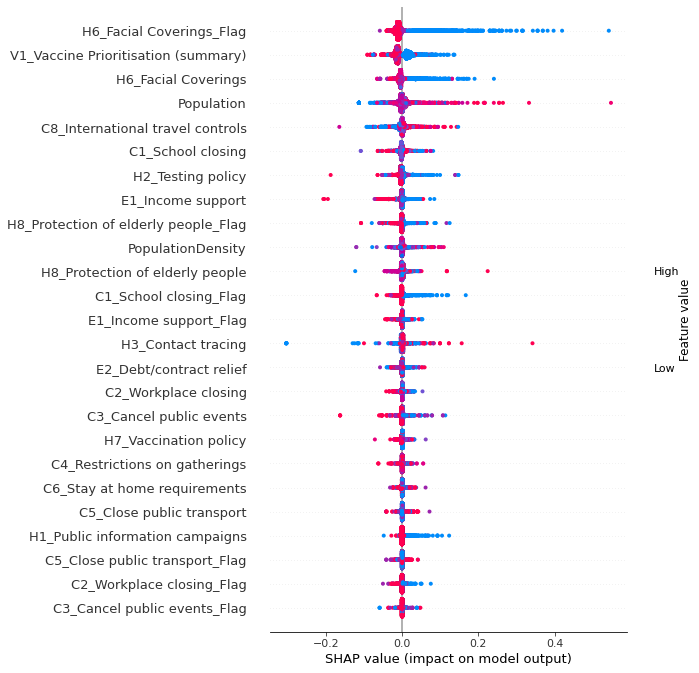

In [36]:
shap.summary_plot(shap_values = shap_values[:,npi_idxs],
                  features = X.iloc[idxs,npi_idxs],
                  max_display=n_features,
                  plot_type='dot',
                  show=False
                 )
plt.savefig('figs/shap_fdot_{}.jpg'.format(n_features), bbox_inches='tight', dpi=128)

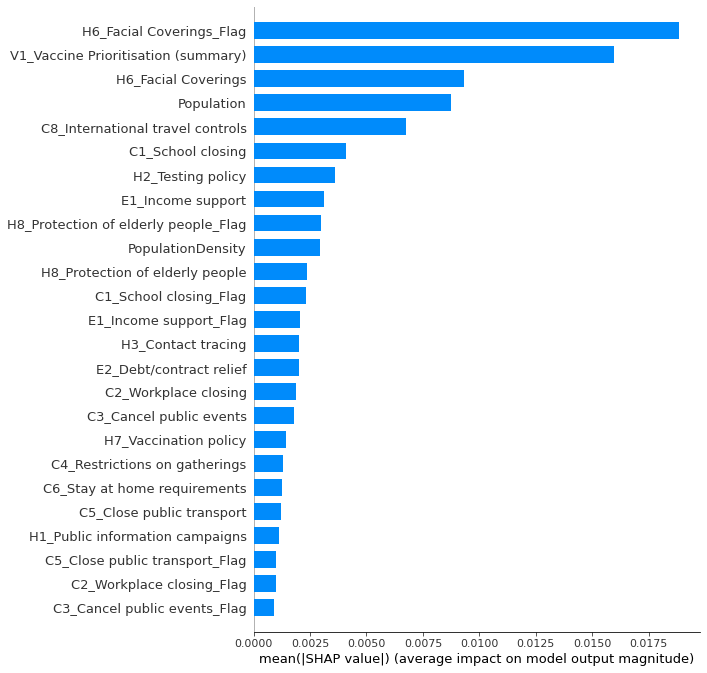

In [37]:
shap.summary_plot(shap_values = shap_values[:,npi_idxs],
                  features = X.iloc[idxs,npi_idxs],
                  max_display=n_features,
                  plot_type='bar',
                  show=False
                 )
plt.savefig('figs/shap_fbar_{}.jpg'.format(n_features), bbox_inches='tight', dpi=128)

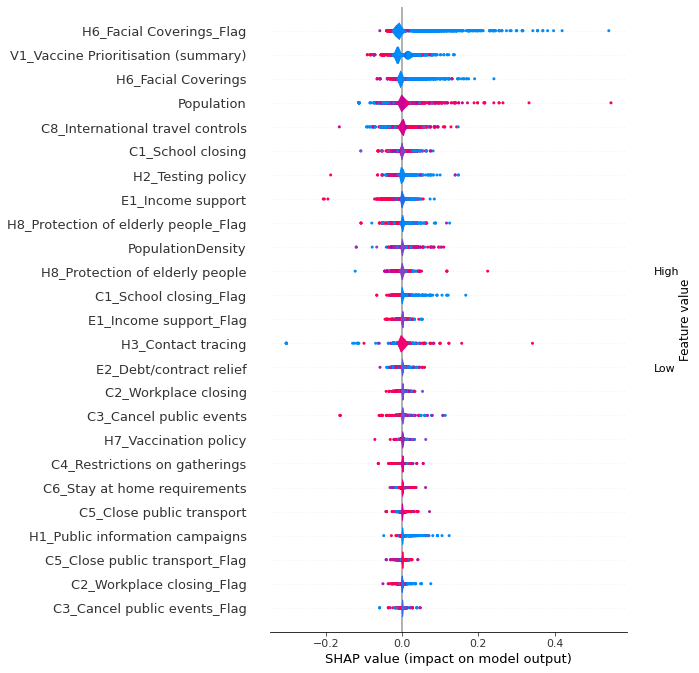

In [38]:
shap.summary_plot(shap_values = shap_values[:,npi_idxs],
                  features = X.iloc[idxs,npi_idxs],
                  max_display=n_features,
                  plot_type='violin',
                  show=False
                 )
plt.savefig('figs/shap_fviolin_{}.jpg'.format(n_features), bbox_inches='tight', dpi=128)

## Plot for country Features

In [11]:
countries = list(filter(lambda x: 'Country' in x, X.columns))
# print(countries)
country_idxs = [X.columns.get_loc(c) for c in countries]

['Country_Afghanistan', 'Country_Albania', 'Country_Algeria', 'Country_Andorra', 'Country_Angola', 'Country_Argentina', 'Country_Aruba', 'Country_Australia', 'Country_Austria', 'Country_Azerbaijan', 'Country_Bahamas', 'Country_Bahrain', 'Country_Bangladesh', 'Country_Barbados', 'Country_Belarus', 'Country_Belgium', 'Country_Belize', 'Country_Benin', 'Country_Bermuda', 'Country_Bhutan', 'Country_Bolivia', 'Country_Bosnia and Herzegovina', 'Country_Botswana', 'Country_Brazil', 'Country_Brunei', 'Country_Bulgaria', 'Country_Burkina Faso', 'Country_Burundi', 'Country_Cambodia', 'Country_Cameroon', 'Country_Canada', 'Country_Cape Verde', 'Country_Central African Republic', 'Country_Chad', 'Country_Chile', 'Country_China', 'Country_Colombia', 'Country_Comoros', 'Country_Congo', 'Country_Costa Rica', "Country_Cote d'Ivoire", 'Country_Croatia', 'Country_Cuba', 'Country_Cyprus', 'Country_Czech Republic', 'Country_Democratic Republic of Congo', 'Country_Denmark', 'Country_Djibouti', 'Country_Dom

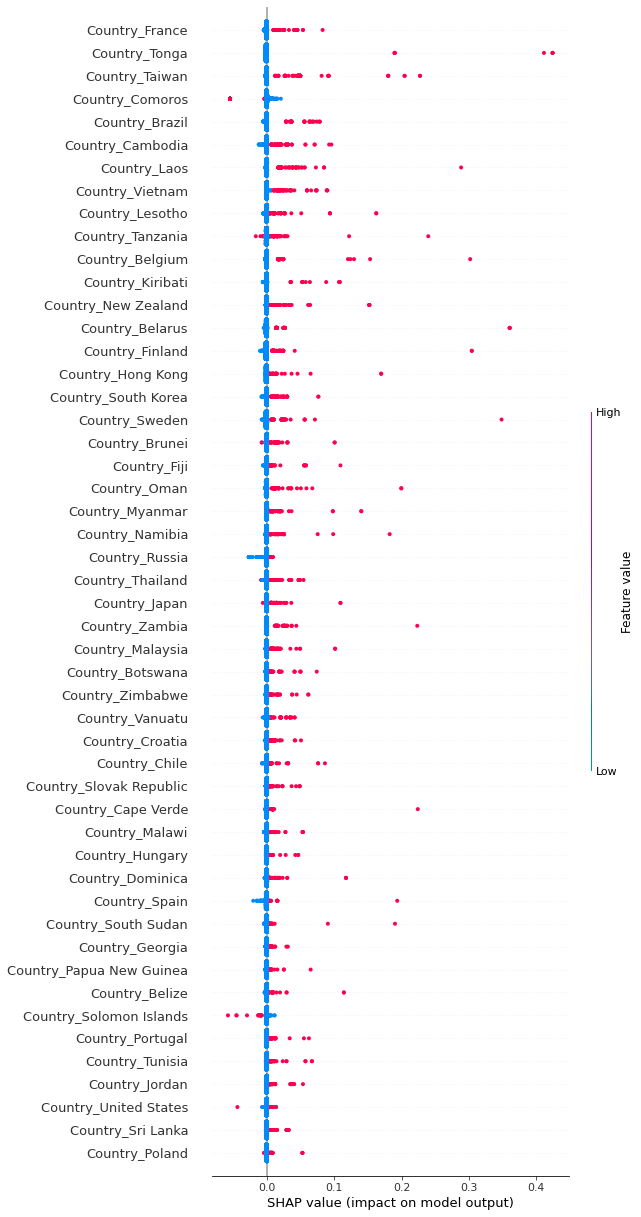

In [19]:
shap.summary_plot(shap_values = shap_values[:,country_idxs],
                  features = X.iloc[idxs,country_idxs],
                  max_display=50,
                  plot_type='dot',
                  show=False
                 )
plt.savefig('figs/shap_cdot.jpg', bbox_inches='tight', dpi=128)

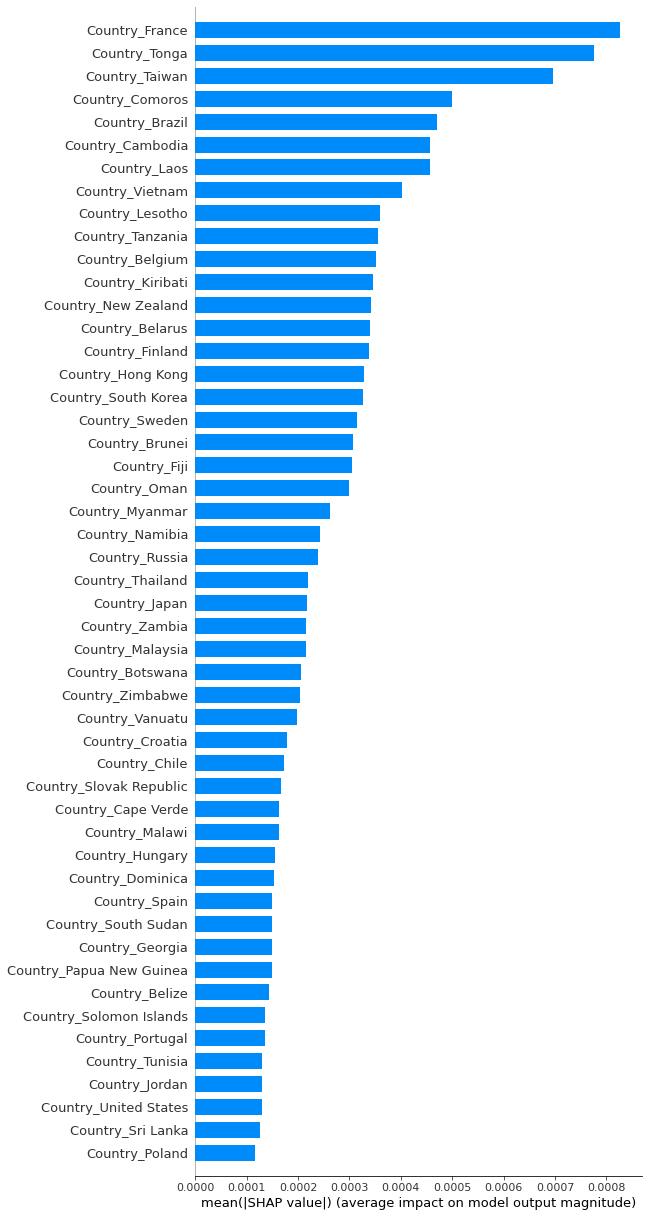

In [20]:
shap.summary_plot(shap_values = shap_values[:,country_idxs],
                  features = X.iloc[idxs,country_idxs],
                  max_display=50,
                  plot_type='bar',
                  show=False
                 )
plt.savefig('figs/shap_cbar.jpg', bbox_inches='tight', dpi=128)

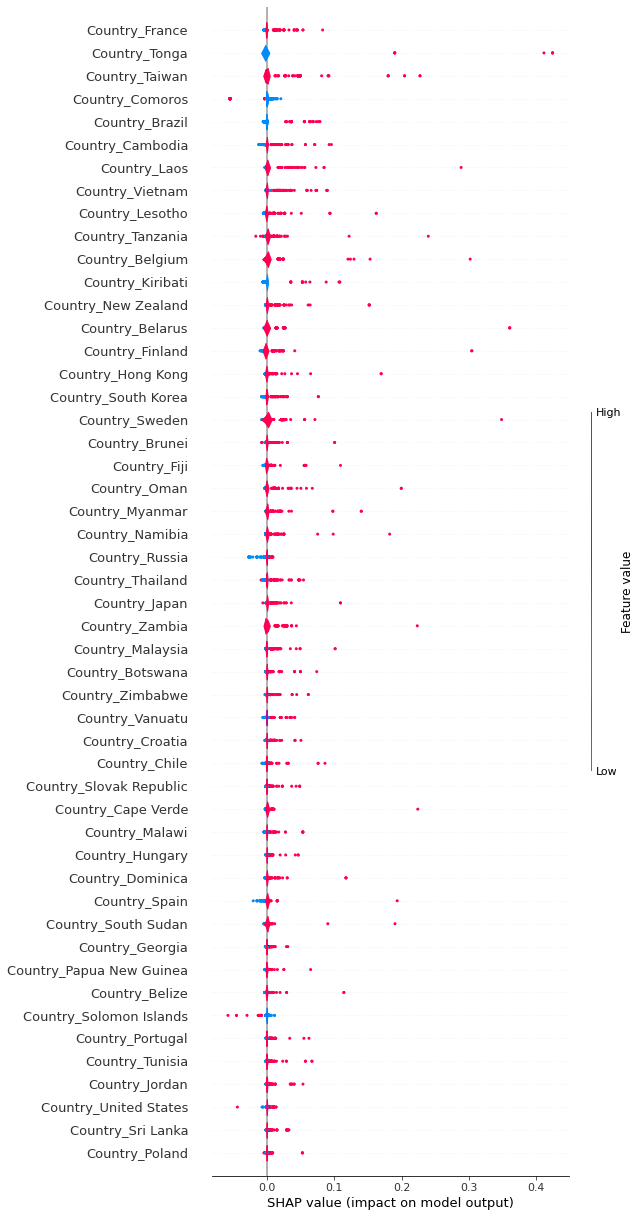

In [22]:
shap.summary_plot(shap_values = shap_values[:,country_idxs],
                  features = X.iloc[idxs,country_idxs],
                  max_display=50,
                  plot_type='violin',
                  show=False
                 )
plt.savefig('figs/shap_cviolin.jpg', bbox_inches='tight', dpi=128)

# Bar with color

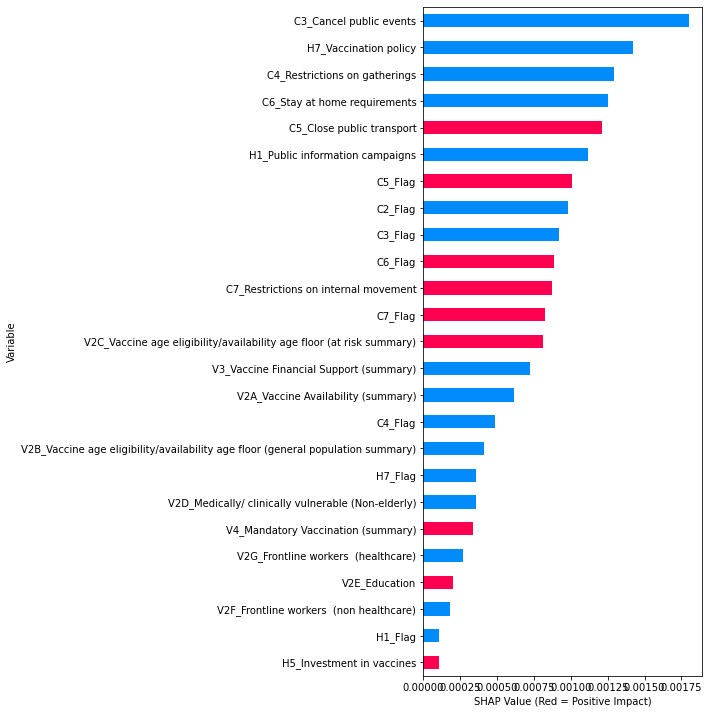

In [15]:
def ABS_SHAP(df_shap,df,max_display=None, **kwargs):
    #import matplotlib as plt
    # Make a copy of the input data
    if max_display is None:
        max_display = df.shape[1]
    
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'#FF0051','#008BFB')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[:max_display]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,0.3*len(feature_list)),
                      legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values[:,npi_idxs], X.iloc[idxs,npi_idxs], n_features, show=False)
plt.savefig('figs/shap_fcolorbar_{}.jpg'.format(n_features), bbox_inches='tight', dpi=128)

## Plot all features (including countries)

In [12]:
# print the JS visualization code to the notebook
shap.initjs()
shap.summary_plot(shap_values = shap_values,
                  features = X.iloc[idxs,:],
                  max_display=50,
                  plot_type='dot',
                  show=False
                 )
f = plt.gcf()
plt.savefig('figs/shap_dot.jpg', bbox_inches='tight', dpi=128)

NameError: name 'idxs' is not defined

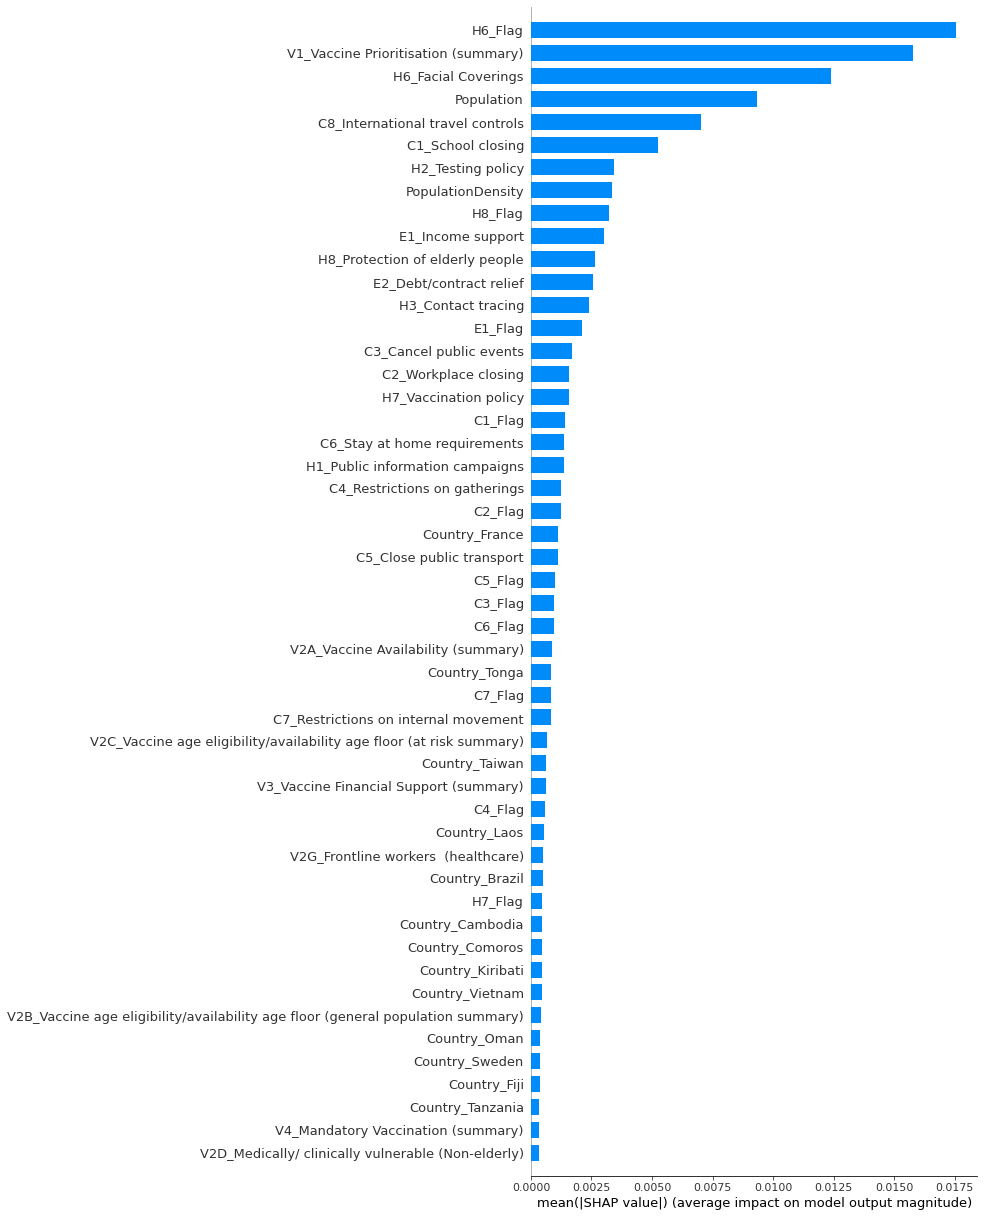

<Figure size 432x288 with 0 Axes>

In [39]:
shap.summary_plot(shap_values = shap_values,
                  features = X.iloc[idxs,:],
                  max_display=50,
                  plot_type='bar'
                 )
plt.savefig('figs/shap_bar.jpg', bbox_inches='tight', dpi=128)

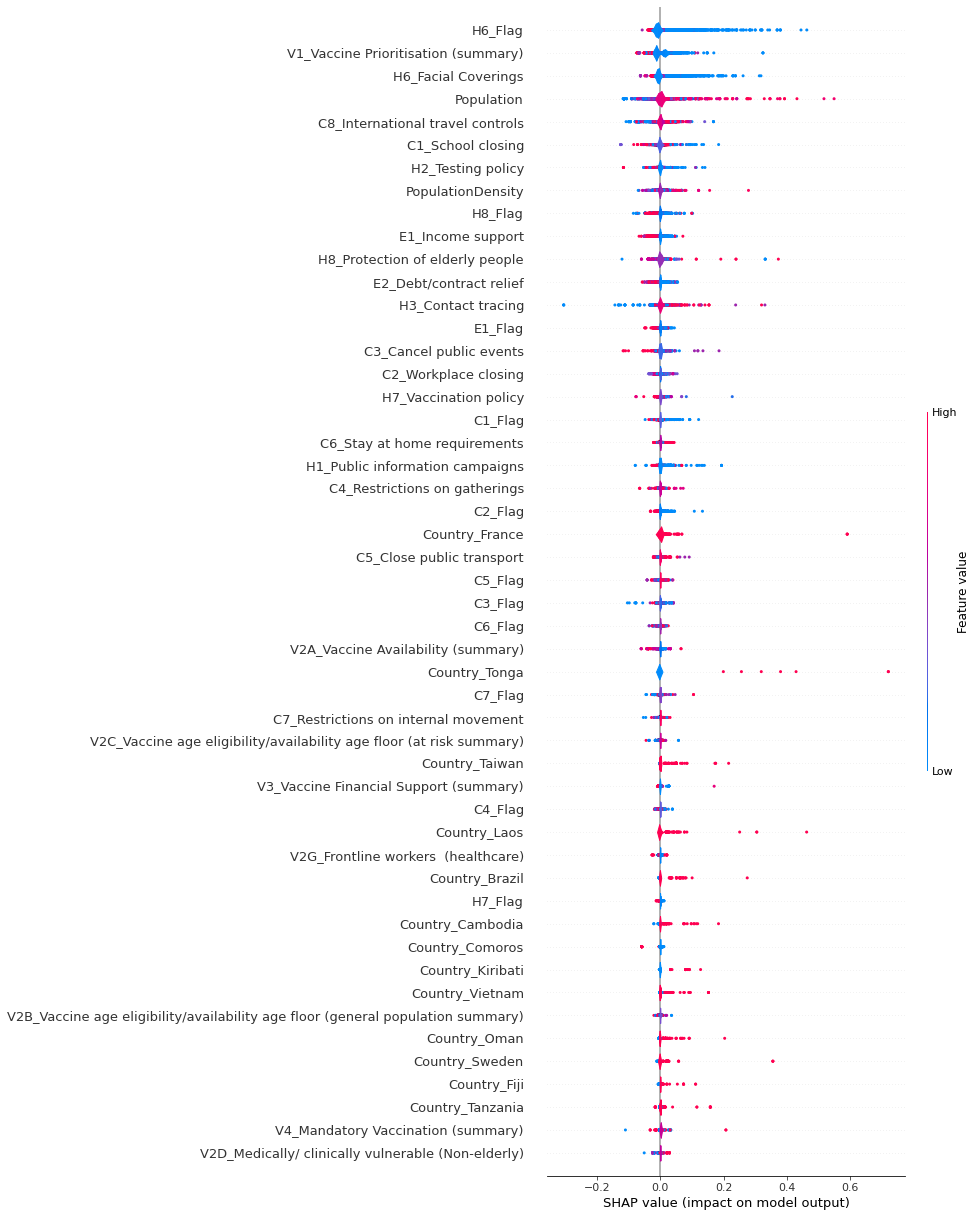

<Figure size 432x288 with 0 Axes>

In [40]:
shap.summary_plot(shap_values = shap_values,
                  features = X.iloc[idxs,:],
                  max_display=50,
                  plot_type='violin'
                 )
plt.savefig('figs/shap_violon.jpg', bbox_inches='tight', dpi=128)

# Inspect data distribution

In [65]:
def plot(col, logx=False, logy=False):
    if logx:
        x = np.log(1+data[col])
    else:
        x = data[col]
    plt.hist(x)
    if logy:
        plt.yscale('log')

interact(plot, col=data.columns)

interactive(children=(Dropdown(description='col', options=('CountryName', 'C1_School closing', 'C1_Flag', 'C2_…

<function __main__.plot(col, logx=False, logy=False)>

# Train RNN

In [3]:
import torch
from rnn import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

%load_ext autoreload
%autoreload 2

In [4]:
data = get_data(drop_ct=False)
train_data = []
test_data = []

for group, df in data.groupby('CountryName'):
    l = df.shape[0]
    train_data.append(df.iloc[:int(0.8*l)].drop(columns='CountryName'))
    # for testing, use the trained data as warmup
    test_data.append(df.drop(columns='CountryName'))


In [5]:
# scale data
cols = train_data[0].columns
scaler = MinMaxScaler()
scaler.fit(pd.concat(train_data))
train_data = [pd.DataFrame(columns=cols, data=scaler.transform(t)) for t in train_data]
tets_data = [pd.DataFrame(columns=cols, data=scaler.transform(t)) for t in test_data]

In [30]:
def train(model, samples, model_name, n_epoch=1):
    optimizer = torch.optim.AdamW(model.parameters(), 1e-4)
    model.train()
    model.cuda()
    
    writer = SummaryWriter(flush_secs=30, log_dir='logs/' + model_name)
    losses = []
    
    n_iter = 1
    for i in range(n_epoch):
        for sample in tqdm(samples):
            sample = {
                'targets': torch.FloatTensor(sample['R_mean'].values).cuda(),
                'features': torch.FloatTensor(sample.drop(columns=['R_mean']).values).cuda()
            }
            loss = model(sample)
            
            writer.add_scalar('Loss/train', loss, n_iter)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.item())
            n_iter += 1
    return losses

def eval(model, samples, portion=0.8):
    model.eval()
    model.cuda()
    
    preds = []
    losses = []
    r2s = []
    with torch.no_grad():
        for sample in tqdm(samples):
            l = sample.shape[0]
            start = int(portion*l)
            seq = {
                'targets': torch.FloatTensor(sample['R_mean'].values[:start]).cuda(),
                'features': torch.FloatTensor(sample.drop(columns=['R_mean']).values).cuda()
            }
            pred = model(seq).cpu().numpy()
            preds.append(pred)
            test_pred = pred[start:]
            test_truth = sample['R_mean'].values[start:]
            losses.append(np.mean((test_pred-test_truth)**2))
            r2s.append(r2_score(test_pred, test_truth))
    
    return preds, np.mean(losses), np.mean(r2s)

In [33]:
model = RNN2(train_data[0].shape[1], 50)
model_name = model.__class__.__name__ + '_' + datetime.now().strftime("%m%d_%H%M")

In [35]:
losses = train(model, train_data, model_name, 30)

100%|█████████████████████████████████████████████████████████████████████| 186/186 [01:31<00:00,  2.02it/s]


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.88it/s]

0.048442481045601185 0.7309193223946515 -10.205985686763173


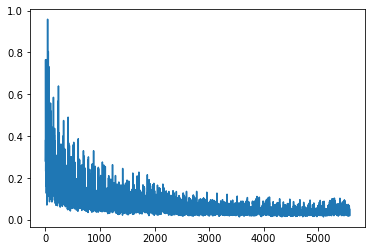

In [36]:
preds, test_loss, test_r2 = eval(model, test_data, 0.4)
plt.plot(losses)
print(np.mean(losses[-len(train_data):]), test_loss, test_r2)

In [269]:
# find countries that are hard to fit
countries = data.CountryName.unique()
countries[np.argsort(-np.array(losses[-len(train_data):]))[:10]]

array(['Tonga', 'Italy', 'Belgium', 'Kiribati', 'Spain', 'Sweden',
       'United States', 'Tanzania', 'Luxembourg', 'Egypt'], dtype=object)

In [37]:
# compare the test result for selected country
def compare(i):
    sample = test_data[i]
    l = sample.shape[0]
    plt.plot(sample['R_mean'].values)
    plt.plot(preds[i])
    plt.legend(['truth', 'pred'])
    
interact(compare, i=(0,len(test_data)))

interactive(children=(IntSlider(value=93, description='i', max=186), Output()), _dom_classes=('widget-interact…

<function __main__.compare(i)>